# Lazy evaluation for vertical interpolation

In [1]:
import numpy as np
import xarray as xr

## Some artificial data

In [2]:
lon = xr.DataArray(np.linspace(-180, 180, 60), dims=("lon", ), name="lon")
lat = xr.DataArray(np.linspace(-90, 90, 30), dims=("lat", ), name="lat")
depth = xr.DataArray(np.linspace(0, - 1000, 10), dims=("depth", ), name="depth")

In [3]:
temperature = xr.DataArray(
    (
        - 2.0  # coldest temp
        + (15 + 15 * np.sin(np.deg2rad(lon)) * np.cos(np.deg2rad(lat)))  # some pattern between 0 and 30 deg
        * np.exp(- np.abs(depth) / 200)  # vertical decay with 200m scale
    ),
    coords={
        "lon": lon,
        "lat": lat,
        "depth": depth,
    }
)

temperature

<xarray.DataArray (lon: 60, lat: 30, depth: 10)>
array([[[13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        ...,
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ]],

       [[13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        [12.82761479,  6.50739471,  2.88114681, ..., -1.69650726,
         -1.82587   , -1.90009232],
        [12.65725064,  6.40964769,  2.82506413, ..., -1.69999428,
         -1.82787069, -1.90124022],
...
        [13.34274936,  6.80295493,  3.0507255 , ..., -1.68596344,
         -1.81982045, -1.89662137],
        [13.17238521,  6.70520791,  2.99464282, ..., -1.68945047,
         -1.82182115, -1.89776927],
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ]],

       [[13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        ...,
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ],
        [13.        ,  6.60630131,  2.93789482, ..., -1.69297886,
         -1.82384557, -1.8989308 ]]])
Coordinates:
  * lon      (lon) float64 -180.0 -173.9 -167.8 -161.7 ... 167.8 173.9 180.0
  * lat      (lat) float64 -90.0 -83.79 -77.59 -71.38 ... 71.38 77.59 83.79 90.0
  * depth    (depth) float64 0.0 -111.1 -222.2 -333.3 ... -777.8 -888.9 -1e+03

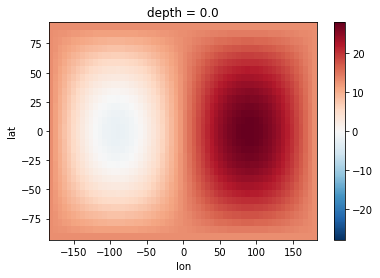

In [4]:
temperature.isel(depth=0).plot(x="lon", y="lat")

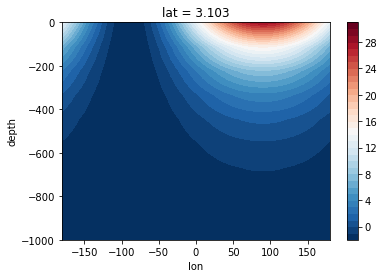

In [5]:
temperature.sel(lat=0, method="nearest").plot.contourf(x="lon", y="depth", levels=np.arange(-2, 32))

## Let's look for the depth of the 0 degree isotherm

### Nearest

In [6]:
target_temp = 0.0

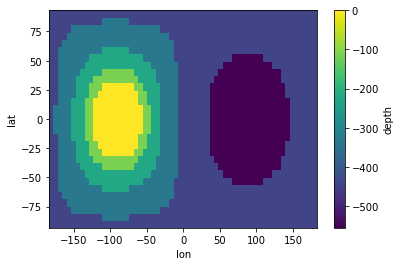

In [7]:
nearest_depth = depth.isel(
    depth=abs(temperature - target_temp).argmin("depth")
)

nearest_depth.plot(x="lon", y="lat")

### Nearest, alternative formulation

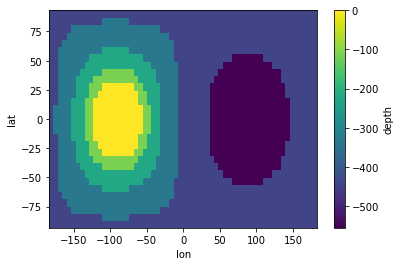

In [8]:
nearest_depth_alt = depth.where(
    abs(temperature - target_temp) == abs(temperature - target_temp).min("depth")
).min("depth")

nearest_depth_alt.plot(x="lon", y="lat")

In [9]:
# zero if equal:
(nearest_depth - nearest_depth_alt).std()

<xarray.DataArray 'depth' ()>
array(0.)

### Interpolation approaches

Only works for monotonic.

In [10]:
index_last_warmer = (
    (temperature >= target_temp).sum("depth") - 1
)
index_first_colder = index_last_warmer + 1

Note these can be out of range:

In [11]:
index_last_warmer.min(), index_last_warmer.max()

(<xarray.DataArray ()>
 array(-1),
 <xarray.DataArray ()>
 array(4))

In [12]:
index_first_colder.min(), index_first_colder.max()

(<xarray.DataArray ()>
 array(0),
 <xarray.DataArray ()>
 array(5))

So we regularize:

In [13]:
index_last_warmer += (index_last_warmer < 0)
index_last_warmer -= (index_last_warmer > len(depth))

index_first_colder += (index_first_colder < 0)
index_first_colder -= (index_first_colder > len(depth))

In [14]:
index_last_warmer.min(), index_last_warmer.max()

(<xarray.DataArray ()>
 array(0),
 <xarray.DataArray ()>
 array(4))

In [15]:
index_first_colder.min(), index_first_colder.max()

(<xarray.DataArray ()>
 array(0),
 <xarray.DataArray ()>
 array(5))

Now do a standard linear regression:

In [16]:
z0 = depth.isel(depth=index_last_warmer)
z1 = depth.isel(depth=index_first_colder)

t0 = temperature.isel(depth=index_last_warmer)
t1 = temperature.isel(depth=index_first_colder)

offset = (
    (z1 - z0) * (target_temp - t0) / (t1 - t0)
)

# make sure to catch where z1 = z0
offset = offset.fillna(0)

interpolated_depth = z0 + offset

interpolated_depth

<xarray.DataArray (lon: 60, lat: 30)>
array([[-409.98901355, -409.98901355, -409.98901355, ..., -409.98901355,
        -409.98901355, -409.98901355],
       [-409.98901355, -407.84963241, -405.68589217, ..., -405.68589217,
        -407.84963241, -409.98901355],
       [-409.98901355, -405.68502021, -401.22900123, ..., -401.22900123,
        -405.68502021, -409.98901355],
       ...,
       [-409.98901355, -414.10067154, -417.98750256, ..., -417.98750256,
        -414.10067154, -409.98901355],
       [-409.98901355, -412.07978037, -414.09987576, ..., -414.09987576,
        -412.07978037, -409.98901355],
       [-409.98901355, -409.98901355, -409.98901355, ..., -409.98901355,
        -409.98901355, -409.98901355]])
Coordinates:
  * lon      (lon) float64 -180.0 -173.9 -167.8 -161.7 ... 167.8 173.9 180.0
  * lat      (lat) float64 -90.0 -83.79 -77.59 -71.38 ... 71.38 77.59 83.79 90.0
    depth    (lon, lat) float64 -333.3 -333.3 -333.3 ... -333.3 -333.3 -333.3

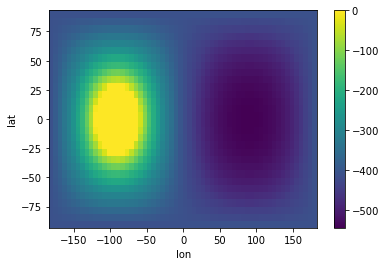

In [17]:
interpolated_depth.plot(x="lon", y="lat");

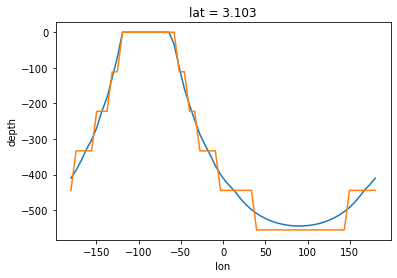

In [18]:
interpolated_depth.sel(lat=0, method="nearest").plot(label="interolated")
nearest_depth.sel(lat=0, method="nearest").plot(label="nearest");